# Notebook 2 for JPX

## Starter

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import gc
import multiprocessing
from IPython.display import display
import random

import sklearn

random.seed(0)
np.random.seed(0)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [2]:
df_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv", parse_dates=['Date'])
df_prices = df_prices[df_prices['Open'].notna()].reset_index(drop=True)
df_prices = df_prices.drop(columns=['RowId'])

f = lambda df: df[::-1].cumprod()[::-1]
df_prices['CumAdjustmentFactor'] = df_prices.groupby('SecuritiesCode')['AdjustmentFactor'].transform(f)
for price in ['Open','High','Low','Close']:
    df_prices[price] *= df_prices['CumAdjustmentFactor']
df_prices['Volume'] /= df_prices['CumAdjustmentFactor']

# not sure, change this later
df_prices['ExpectedDividend'] = df_prices['ExpectedDividend'].fillna(0)
df_prices

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target,CumAdjustmentFactor
0,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400.0,1.0,0.0,False,0.000730,1.0
1,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500.0,1.0,0.0,False,0.012324,1.0
2,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800.0,1.0,0.0,False,0.006154,1.0
3,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300.0,1.0,0.0,False,0.011053,1.0
4,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800.0,1.0,0.0,False,0.003026,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2324918,2021-12-03,9990,514.0,528.0,513.0,528.0,44200.0,1.0,0.0,False,0.034816,1.0
2324919,2021-12-03,9991,782.0,794.0,782.0,794.0,35900.0,1.0,0.0,False,0.025478,1.0
2324920,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200.0,1.0,0.0,False,-0.004302,1.0
2324921,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500.0,1.0,0.0,False,0.009098,1.0


## Features and Train

In [3]:
class Stock:
    def __init__(self, feat):
        '''
        maintain SecuritiesCode, prices, vol, date, target and features for future calculations
        '''
        self.SecuritiesCode = int(feat[0][1])
        openn = feat[:,2].astype(np.float32)
        high = feat[:,3].astype(np.float32)
        low = feat[:,4].astype(np.float32)
        close = feat[:,5].astype(np.float32)
        self.price = (openn+high+low+close)/4
        
        self.vol = feat[:,6].astype(np.float32)
        AdjustmentFactor = feat[:,7].astype(np.float32)
        ExpectedDividend = feat[:,8].astype(np.float32)
        
        # returns
        log_ret = np.log(self.price[1:]/self.price[:-1])
        
        # volume
        log_chg_vol = np.log(self.vol[1:]/self.vol[:-1])
        
        # daily volitality
        daily_chg_log = np.log(high/low)
        
        # volitality
        std5 = self.give_std(5, log_ret)
        std5_chg = np.log(std5[1:]/(std5[:-1]+1e-16) + 1e-16)
        
        # others
        rsi7 = self.give_rsi(7, log_ret)
                
        N = np.min((std5_chg.shape[0], rsi7.shape[0]))
        self.feat = np.stack((AdjustmentFactor[-N:],
                              ExpectedDividend[-N:],
                              log_ret[-N:],
                              log_ret[-N-1:-1],
                              log_ret[-N-2:-2],
                              log_ret[-N-3:-3],
                              log_ret[-N-4:-4],
                              log_ret[-N-5:-5],
                              log_ret[-N-6:-6],
                              log_chg_vol[-N:],
                              log_chg_vol[-N-1:-1],
                              log_chg_vol[-N-2:-2],
                              daily_chg_log[-N:],
                              daily_chg_log[-N-1:-1],
                              daily_chg_log[-N-2:-2],
                              std5[-N:],
                              std5_chg[-N:],
                              rsi7[-N:],           
                             ), axis=1)
        
        # target = feat[-N:,10].astype(np.float32)
        self.target = log_ret[-N+2:]

        self.price = self.price[:-2]
        self.vol = self.vol[:-2]
        self.feat = self.feat[:-2]
        self.Date = feat[-N:-2,0]
        
    def give_std(self, wsize, log_ret):
        return np.array([np.std(log_ret[i+1-wsize:i+1]) for i in range(wsize-1,len(log_ret))], dtype=np.float32)
    
    def give_rsi(self, rs_wsize, log_ret):
        gain = np.where(log_ret>0, log_ret, 0.0)
        loss = np.where(log_ret<0, -log_ret, 0.0)
        rs = np.array([np.mean(gain[i+1-rs_wsize:i+1]) / (np.mean(loss[i+1-rs_wsize:i+1])+1e-16) for i in range(rs_wsize-1,len(gain))], dtype=np.float32)
        return 100 - 100/(1+ rs)
    
    def add_row(self, feat):
        '''
        updates all data structures in the class with new data
        and return the feature row added 
        '''
        price = (feat[2] + feat[3] + feat[4] + feat[5]) / 4
        
        AdjustmentFactor = feat[7]
        ExpectedDividend = feat[8]
        
        self.price = np.append(self.price * AdjustmentFactor, price)
        self.vol   = np.append(self.vol / AdjustmentFactor, feat[6])
        
        self.Date = np.append(self.Date, feat[0])
        
        # target = feat[10]
        # self.target = np.append(self.target, target)
        
        log_ret = np.log(self.price[-1]/self.price[-2])
        log_chg_vol = np.log(self.vol[-1]/self.vol[-2])
        daily_chg_log = np.log(feat[3] / feat[4])
        std5 = np.std(np.append(self.feat[-4:,2], log_ret))
        std5_chg = np.log(std5/(self.feat[-1,-3]+1e-16) + 1e-16)
                
        # others
        rsi7 = self.give_rsi(7, np.append(self.feat[-6:,2], log_ret)).item()
        
        feat_row = np.array([AdjustmentFactor,
                             ExpectedDividend,
                             log_ret,
                             self.feat[-1,2],
                             self.feat[-2,2],
                             self.feat[-3,2],
                             self.feat[-4,2],
                             self.feat[-5,2],
                             self.feat[-6,2],
                             log_chg_vol,
                             self.feat[-1,9],
                             self.feat[-2,9],
                             daily_chg_log,
                             self.feat[-1,-6],
                             self.feat[-2,-6],
                             std5,
                             std5_chg,
                             rsi7
                            ], dtype=np.float32).reshape(1,-1)
        
        self.feat = np.concatenate((self.feat, feat_row))
        return feat_row.reshape(-1)
        
    def give_date_features(self, date):
        if date not in self.Date:
            return None
        idx = np.search_sorted(self.Date, date)
        return self.feat[idx]

In [4]:
X_train = None

stocks = []

for i in tqdm(np.unique(df_prices['SecuritiesCode']).tolist()):
    stock = Stock(df_prices[df_prices['SecuritiesCode']==i].values)

    stocks.append(stock)
    
    X = stock.feat
    y = stock.target

    split = int(len(y) * 0.8)
    if X_train is None:
        X_train = X[:split,:]
        X_valid = X[split:,:]
        y_train = y[:split]
        y_valid = y[split:]
    else:
        X_train = np.concatenate((X_train, X[:split,:]))
        X_valid = np.concatenate((X_valid, X[split:,:]))
        y_train = np.concatenate((y_train, y[:split]))
        y_valid = np.concatenate((y_valid, y[split:]))

100%|██████████| 2000/2000 [04:31<00:00,  7.37it/s]


In [5]:
model1 = lgb.LGBMRegressor(learning_rate=0.02, n_estimators=256, boosting_type='gbdt')
model1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's l2: 0.000300516


LGBMRegressor(learning_rate=0.02, n_estimators=256)

In [6]:
model2 = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100, boosting_type='gbdt')
model2.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's l2: 0.000300519


LGBMRegressor()

In [7]:
model3 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100, boosting_type='gbdt')
model3.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.000300546


LGBMRegressor(learning_rate=0.01)

In [8]:
model4 = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100, boosting_type='gbdt', reg_alpha=10.0, reg_lambda=10.0)
model4.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.000300564


LGBMRegressor(learning_rate=0.01, reg_alpha=10.0, reg_lambda=10.0)

In [9]:
model5 = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100, boosting_type='goss')
model5.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.000300493


LGBMRegressor(boosting_type='goss')

In [10]:
model6 = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=100, boosting_type='goss', reg_alpha=10.0, reg_lambda=10.0)
model6.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks=[lgb.early_stopping(10)])

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 0.000300537


LGBMRegressor(boosting_type='goss', reg_alpha=10.0, reg_lambda=10.0)

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

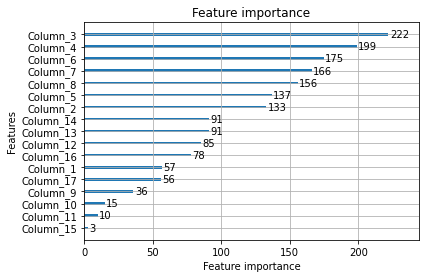

In [11]:
lgb.plot_importance(model1)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

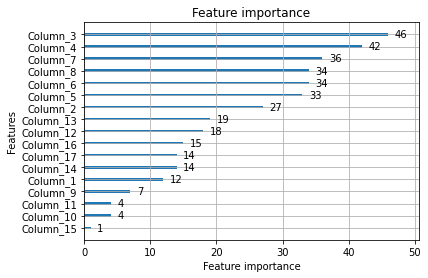

In [12]:
lgb.plot_importance(model2)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

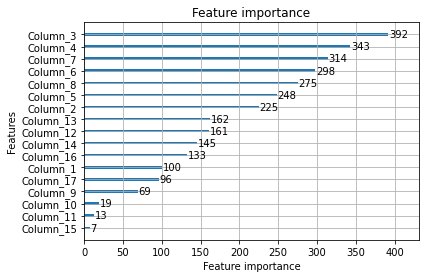

In [13]:
lgb.plot_importance(model3)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

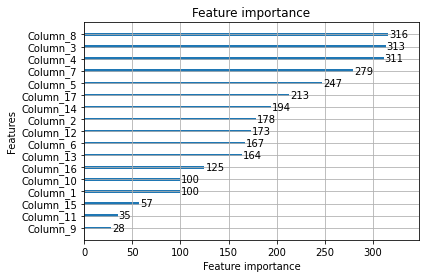

In [14]:
lgb.plot_importance(model4)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

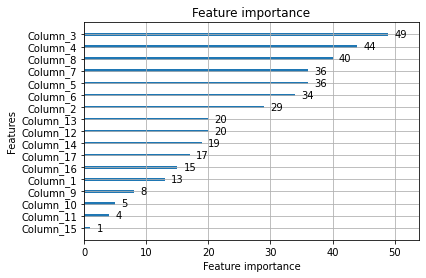

In [15]:
lgb.plot_importance(model5)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

'\n0 AdjustmentFactor[-N:],\n1 ExpectedDividend[-N:],\n2 log_ret[-N:],\n3 log_ret[-N-1:-1],\n4 log_ret[-N-2:-2],\n5 log_ret[-N-3:-3],\n6 log_ret[-N-4:-4],\n7 log_ret[-N-5:-5],\n8 log_ret[-N-6:-6],\n9 log_chg_vol[-N:],\n0 log_chg_vol[-N-1:-1],\n1 log_chg_vol[-N-2:-2],\n2 daily_chg_log[-N:],\n3 daily_chg_log[-N-1:-1],\n4 daily_chg_log[-N-2:-2],\n5 std5[-N:],\n6 std5_chg[-N:],\n7 rsi7[-N:],\n'

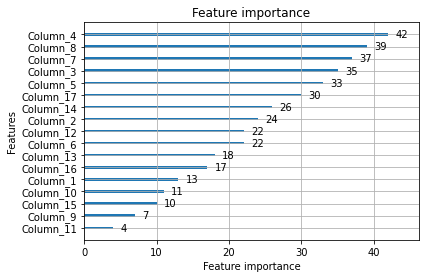

In [16]:
lgb.plot_importance(model6)
'''
0 AdjustmentFactor[-N:],
1 ExpectedDividend[-N:],
2 log_ret[-N:],
3 log_ret[-N-1:-1],
4 log_ret[-N-2:-2],
5 log_ret[-N-3:-3],
6 log_ret[-N-4:-4],
7 log_ret[-N-5:-5],
8 log_ret[-N-6:-6],
9 log_chg_vol[-N:],
0 log_chg_vol[-N-1:-1],
1 log_chg_vol[-N-2:-2],
2 daily_chg_log[-N:],
3 daily_chg_log[-N-1:-1],
4 daily_chg_log[-N-2:-2],
5 std5[-N:],
6 std5_chg[-N:],
7 rsi7[-N:],
'''

In [17]:
from sklearn.metrics import r2_score
y_pred1 = model1.predict(X_valid)
r2_score(y_valid, y_pred1)

0.0029376412807538

In [18]:
y_pred2 = model2.predict(X_valid)
r2_score(y_valid, y_pred2)

0.0029274770776989145

In [19]:
y_pred3 = model3.predict(X_valid)
r2_score(y_valid, y_pred3)

0.002837600313865707

In [20]:
y_pred4 = model4.predict(X_valid)
r2_score(y_valid, y_pred4)

0.0027769915998856476

In [21]:
y_pred5 = model5.predict(X_valid)
r2_score(y_valid, y_pred5)

0.003012865850815283

In [22]:
y_pred6 = model6.predict(X_valid)
r2_score(y_valid, y_pred6)

0.0028671873434441553

In [23]:
y_pred = (y_pred1 + y_pred2 + y_pred3 + y_pred4 + y_pred5 + y_pred6) / 6
r2_score(y_valid, y_pred)

0.0030277917177837788

## Testing

In [24]:
scode_dict = {}
for i in range(len(stocks)):
    scode_dict[stocks[i].SecuritiesCode] = i

In [25]:
df_sprices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv", parse_dates=['Date'])
df_sprices = df_sprices[df_sprices['Open'].notna()].reset_index(drop=True)
df_sprices = df_sprices.drop(columns=['RowId'])
df_sprices['ExpectedDividend'] = df_sprices['ExpectedDividend'].fillna(0)
df_sprices

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,2021-12-06,1301,2982.0,2982.0,2965.0,2971.0,8900,1.0,0.0,False,-0.003263
1,2021-12-06,1332,592.0,599.0,588.0,589.0,1360800,1.0,0.0,False,-0.008993
2,2021-12-06,1333,2368.0,2388.0,2360.0,2377.0,125900,1.0,0.0,False,-0.009963
3,2021-12-06,1375,1230.0,1239.0,1224.0,1224.0,81100,1.0,0.0,False,-0.015032
4,2021-12-06,1376,1339.0,1372.0,1339.0,1351.0,6200,1.0,0.0,False,0.002867
...,...,...,...,...,...,...,...,...,...,...,...
269058,2022-06-24,9990,576.0,576.0,563.0,564.0,24200,1.0,0.0,False,0.027073
269059,2022-06-24,9991,810.0,815.0,804.0,815.0,8700,1.0,0.0,False,0.001220
269060,2022-06-24,9993,1548.0,1548.0,1497.0,1497.0,12600,1.0,0.0,False,0.001329
269061,2022-06-24,9994,2507.0,2527.0,2498.0,2527.0,7300,1.0,0.0,False,0.003185


In [26]:
test_dates = np.unique(df_sprices['Date'].values)
test_dates

array(['2021-12-06T00:00:00.000000000', '2021-12-07T00:00:00.000000000',
       '2021-12-08T00:00:00.000000000', '2021-12-09T00:00:00.000000000',
       '2021-12-10T00:00:00.000000000', '2021-12-13T00:00:00.000000000',
       '2021-12-14T00:00:00.000000000', '2021-12-15T00:00:00.000000000',
       '2021-12-16T00:00:00.000000000', '2021-12-17T00:00:00.000000000',
       '2021-12-20T00:00:00.000000000', '2021-12-21T00:00:00.000000000',
       '2021-12-22T00:00:00.000000000', '2021-12-23T00:00:00.000000000',
       '2021-12-24T00:00:00.000000000', '2021-12-27T00:00:00.000000000',
       '2021-12-28T00:00:00.000000000', '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2022-01-04T00:00:00.000000000',
       '2022-01-05T00:00:00.000000000', '2022-01-06T00:00:00.000000000',
       '2022-01-07T00:00:00.000000000', '2022-01-11T00:00:00.000000000',
       '2022-01-12T00:00:00.000000000', '2022-01-13T00:00:00.000000000',
       '2022-01-14T00:00:00.000000000', '2022-01-17

In [27]:
# see how to adjust for splits
feat_rows = []
meta_data = []
for date in tqdm(test_dates):
    feat_date = df_sprices[df_sprices['Date']==date].values
    for raw_row in feat_date:
        scode = raw_row[1]
        feat_row = stocks[scode_dict[scode]].add_row(raw_row)
        feat_rows.append(feat_row)
        meta_data.append([raw_row[0], raw_row[1], raw_row[-1]])

100%|██████████| 135/135 [01:09<00:00,  1.94it/s]


In [28]:
feat_rows = np.array(feat_rows, dtype=np.float32)
feat_rows

array([[ 1.0000000e+00,  0.0000000e+00,  1.9945495e-02, ...,
         1.1483550e-02,  1.4280883e+00,  3.2214012e+01],
       [ 1.0000000e+00,  0.0000000e+00,  3.4367643e-02, ...,
         2.0403251e-02,  6.2991971e-01,  4.8322098e+01],
       [ 1.0000000e+00,  0.0000000e+00,  3.8441494e-02, ...,
         2.0633344e-02,  8.8951582e-01,  5.1567486e+01],
       ...,
       [ 1.0000000e+00,  0.0000000e+00, -8.5023399e-03, ...,
         6.2921457e-03,  5.1849842e-01,  7.1810791e+01],
       [ 1.0000000e+00,  0.0000000e+00,  9.0877945e-03, ...,
         3.5268564e-03,  6.5827340e-01,  9.6479836e+01],
       [ 1.0000000e+00,  0.0000000e+00,  1.2649501e-02, ...,
         5.9382627e-03, -3.5668036e-01,  8.3388290e+01]], dtype=float32)

In [29]:
meta_data = np.array(meta_data)
meta_data

array([[Timestamp('2021-12-06 00:00:00'), 1301, -0.0032626427406199],
       [Timestamp('2021-12-06 00:00:00'), 1332, -0.0089928057553957],
       [Timestamp('2021-12-06 00:00:00'), 1333, -0.0099626400996264],
       ...,
       [Timestamp('2022-06-24 00:00:00'), 9993, 0.001328903654485],
       [Timestamp('2022-06-24 00:00:00'), 9994, 0.0031847133757962],
       [Timestamp('2022-06-24 00:00:00'), 9997, 0.0150891632373113]],
      dtype=object)

In [30]:
pred1 = model1.predict(feat_rows)
pred2 = model2.predict(feat_rows)
pred3 = model3.predict(feat_rows)
pred4 = model4.predict(feat_rows)
pred5 = model5.predict(feat_rows)
pred6 = model6.predict(feat_rows)

In [31]:
pred = (pred1 + pred2 + pred3 + pred4 + pred5 + pred6) / 6

In [32]:
preds = np.concatenate((meta_data, pred.reshape(-1,1)), axis=1)
preds

array([[Timestamp('2021-12-06 00:00:00'), 1301, -0.0032626427406199,
        0.00018297295794946844],
       [Timestamp('2021-12-06 00:00:00'), 1332, -0.0089928057553957,
        0.0001311408786899418],
       [Timestamp('2021-12-06 00:00:00'), 1333, -0.0099626400996264,
        6.93932901237923e-05],
       ...,
       [Timestamp('2022-06-24 00:00:00'), 9993, 0.001328903654485,
        0.00018723274747922412],
       [Timestamp('2022-06-24 00:00:00'), 9994, 0.0031847133757962,
        0.0001311408786899418],
       [Timestamp('2022-06-24 00:00:00'), 9997, 0.0150891632373113,
        6.93932901237923e-05]], dtype=object)

In [33]:
preds = pd.DataFrame(preds, columns=['Date', 'SecuritiesCode', 'Target', 'pred'])
preds

,Date,SecuritiesCode,Target,pred
0,2021-12-06,1301,-0.003263,0.000183
1,2021-12-06,1332,-0.008993,0.000131
2,2021-12-06,1333,-0.009963,0.000069
3,2021-12-06,1375,-0.015032,0.000292
4,2021-12-06,1376,0.002867,0.000148
...,...,...,...,...
269058,2022-06-24,9990,0.027073,0.000071
269059,2022-06-24,9991,0.00122,0.000145
269060,2022-06-24,9993,0.001329,0.000187
269061,2022-06-24,9994,0.003185,0.000131


In [34]:
def set_rank(df):
    df = df.sort_values(by='pred')
    df['Rank'] = np.arange(0, df.shape[0])[::-1]
    df = df.sort_index()
    return df

submission = preds.groupby('Date').apply(set_rank)#.reset_index(drop=True)

In [35]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

calc_spread_return_sharpe(submission)

0.1800110492612728